In [150]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp

pt = 4/3
halfsize = (3, 3/1.618)
fullsize = (5, 5/1.618)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

pool = mp.Pool(processes=10)

In [21]:
def double_well(x,a=0.1,b=1):
    return a*((x/b)**2-1)**2

def double_well_function(a=0.1):
    return lambda x: double_well(x, a=a)

def step(x,pot,dx=0.01):
    dx = np.random.choice([-1,1],len(x))*dx
    return x + (np.random.random(len(x))<np.exp(-pot(x+dx)+pot(x)))*dx
def do_sim(num_steps,num_traj,pot,xinit=0):
    x = np.ones((num_steps,num_traj))*xinit
    i_init = np.zeros(num_traj)
    mask = np.zeros(num_traj)
    jump_times = np.zeros(10*num_traj)
    num_jumps = 0
    for i in range(0,num_steps):
        x[i] = step(x[i-1],pot)
        mask = x[i] < 0
        jump_times[num_jumps:num_jumps+np.sum(mask)] = i - i_init[mask]
        x[i][mask]=xinit
        num_jumps += np.sum(mask)
        i_init[mask] = i
        if num_jumps>1000:
            break
    jump_times = jump_times[0:num_jumps]
    return x, jump_times

def plot_sim(x):
    for j in range(0,x.shape[1]):
        plt.plot(x[:,j])

/tmp/ipykernel_1244286/1918441753.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(a_list.min(), a_list.max())), label=r"$a$")


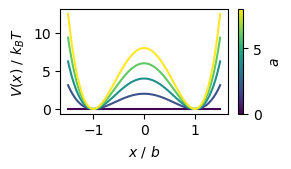

In [64]:
# plot the potential

plt.figure(figsize=halfsize)
x_list = np.linspace(-1.5,1.5, 100)
a_list = np.arange(0, 10, 2)
color = plt.cm.viridis(a_list/np.max(a_list))
for a,c in zip(a_list, color):
	plt.plot(x_list, double_well(x_list, a=a), color=c, label=f"a={a}")

plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(a_list.min(), a_list.max())), label=r"$a$")
plt.xlabel(r"$x$ / $b$")
plt.ylabel(r"$V(x)$ / $k_B T$")
plt.tight_layout()
plt.savefig("../figures/04 potential.pdf")
plt.show()

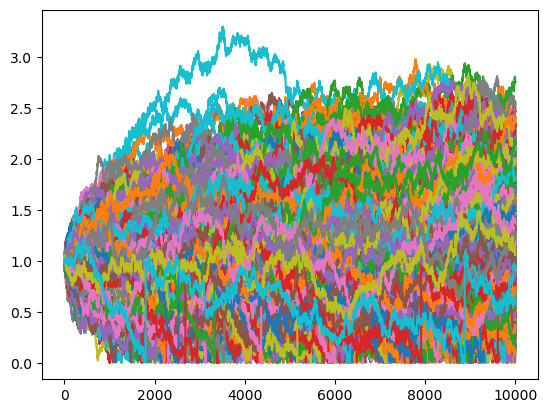

CPU times: user 3.57 s, sys: 401 ms, total: 3.97 s
Wall time: 3.99 s


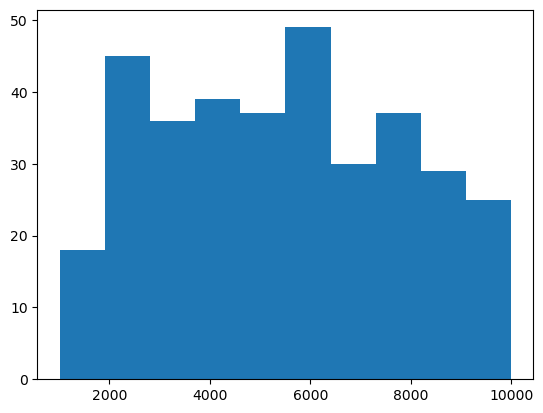

In [6]:
%%time
x, jumps = do_sim(10000,1000,double_well_function(0.1),xinit=1)
plot_sim(x); plt.show();
plt.hist(jumps);

In [160]:
%%time
def find_jump_times(num_traj,pot,xinit=0,num_jump_lim=10):
	x = np.ones(num_traj)*xinit
	i_init = np.zeros(num_traj)
	mask = np.zeros(num_traj)
	jump_times = np.zeros(num_jump_lim)
	num_jumps = 0
	i = 0
	while num_jumps<num_jump_lim:
			x = step(x,pot)
			mask = x < 0
			jump_times[num_jumps:num_jumps+np.sum(mask)] = i - i_init[mask]
			x[mask]=xinit
			num_jumps += np.sum(mask)
			i_init[mask] = i
			i+=1
	print(f"steps: {i}")
	return jump_times

a = np.linspace(1, 5, 10)

def do_do_sim_2(a):
	return find_jump_times(1,double_well_function(a), xinit=1, num_jump_lim=20)

jumps = pool.map(do_do_sim_2, a)
jumps = np.array(jumps)

CPU times: user 9.04 ms, sys: 7.69 ms, total: 16.7 ms
Wall time: 49.9 s


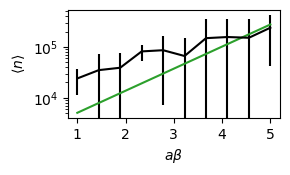

In [161]:
from scipy.optimize import curve_fit
def mdl(a, p): return p*np.exp(a)
popt, pcov = curve_fit(mdl, a, np.mean(jumps, axis=1))


plt.figure(figsize=halfsize)

plt.errorbar(a, np.mean(jumps, axis=1), np.std(jumps, axis=1), color="black")
a_list = np.linspace(min(a), max(a), 100)
plt.plot(a_list, popt[0]*np.exp(a_list), color=colors[2])
plt.yscale("log")
plt.xlabel(r"$a\beta$")
plt.ylabel(r"$\langle n \rangle$")
plt.tight_layout()
plt.savefig("../figures/04 chem.pdf")
plt.show()

In [159]:
popt[0], np.sqrt(pcov[0, 0])

(2402.9898827962206, 339.81862251093276)